## Application of Support Vector Machine to Flow Loop data stream

This code is based on the SVM ipython notebook generated by Cedric for the October, 2021 analysis of EPRI Flow Data. The version here is meant to process the Flow Loop data and look for the changes to the data stream produced by physical anomalies, as indicated by the notebook provided by Lea Boche and Christina Lawson (EPRI). 

In [37]:
import numpy as np
import pandas as pd
import datetime as dt
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (50,25)
%matplotlib inline
import seaborn as sns
import sys
import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.svm import SVC
from sklearn.metrics import auc, roc_auc_score, mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.inspection import permutation_importance

sys.path.append('/Users/j.wagg/DataScience/S2DS/EPRI/NewData2022/Logs')
from lablog_parser import *
from custom_metric import cedric_metric_binary
from custom_metric import cedric_metric_nonbinary

import timeit

pd.set_option("display.max.columns", None)
pd.set_option("display.max_rows", None)
print("Setup Complete")


Setup Complete


In [38]:
# reading in the flow loop data training sample 
flow_data = pd.read_csv("final.csv")
flow_data.keys()


Index(['Unnamed: 0', 'max_FIT102_Raw_Signal', 'min_FIT102_Raw_Signal',
       'mean_FIT102_Raw_Signal', 'std_FIT102_Raw_Signal',
       'max_FIT202_Raw_Signal', 'min_FIT202_Raw_Signal',
       'mean_FIT202_Raw_Signal', 'std_FIT202_Raw_Signal',
       'max_LIT101_Raw_Signal', 'min_LIT101_Raw_Signal',
       'mean_LIT101_Raw_Signal', 'std_LIT101_Raw_Signal',
       'max_LIT201_Raw_Signal', 'min_LIT201_Raw_Signal',
       'mean_LIT201_Raw_Signal', 'std_LIT201_Raw_Signal',
       'max_PIT101_Raw_Signal', 'min_PIT101_Raw_Signal',
       'mean_PIT101_Raw_Signal', 'std_PIT101_Raw_Signal',
       'max_PIT102_Raw_Signal', 'min_PIT102_Raw_Signal',
       'mean_PIT102_Raw_Signal', 'std_PIT102_Raw_Signal',
       'max_PIT201_Raw_Signal', 'min_PIT201_Raw_Signal',
       'mean_PIT201_Raw_Signal', 'std_PIT201_Raw_Signal',
       'max_PIT202_Raw_Signal', 'min_PIT202_Raw_Signal',
       'mean_PIT202_Raw_Signal', 'std_PIT202_Raw_Signal',
       'max_SI102_Raw_Signal', 'min_SI102_Raw_Signal', 'mean_SI102

In [39]:
# add a new column to the data frame so that anomalies appear as binary 1 yes/0 no anomaly
# we can then use this for the Neural Network (just convert the 'label' column)
flow_data['bin_anomaly'] = 0

for index in flow_data.index:
    if flow_data['target'][index] != 'normal':
        flow_data.at[index,'bin_anomaly'] = 1

## SVM binary approach to classification of anomalies

In [40]:
drop_list = ['Unnamed: 0','target']

value = 'bin_anomaly'
print(flow_data['bin_anomaly'].describe())

count    14304.000000
mean         0.276636
std          0.447351
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: bin_anomaly, dtype: float64


In [41]:
learning_features = ['max_FIT102_Raw_Signal', 'min_FIT102_Raw_Signal',
       'mean_FIT102_Raw_Signal', 'std_FIT102_Raw_Signal',
       'max_FIT202_Raw_Signal', 'min_FIT202_Raw_Signal',
       'mean_FIT202_Raw_Signal', 'std_FIT202_Raw_Signal',
       'max_LIT101_Raw_Signal', 'min_LIT101_Raw_Signal',
       'mean_LIT101_Raw_Signal', 'std_LIT101_Raw_Signal',
       'max_LIT201_Raw_Signal', 'min_LIT201_Raw_Signal',
       'mean_LIT201_Raw_Signal', 'std_LIT201_Raw_Signal',
       'max_PIT101_Raw_Signal', 'min_PIT101_Raw_Signal',
       'mean_PIT101_Raw_Signal', 'std_PIT101_Raw_Signal',
       'max_PIT102_Raw_Signal', 'min_PIT102_Raw_Signal',
       'mean_PIT102_Raw_Signal', 'std_PIT102_Raw_Signal',
       'max_PIT201_Raw_Signal', 'min_PIT201_Raw_Signal',
       'mean_PIT201_Raw_Signal', 'std_PIT201_Raw_Signal',
       'max_PIT202_Raw_Signal', 'min_PIT202_Raw_Signal',
       'mean_PIT202_Raw_Signal', 'std_PIT202_Raw_Signal',
       'max_SI102_Raw_Signal', 'min_SI102_Raw_Signal', 'mean_SI102_Raw_Signal',
       'std_SI102_Raw_Signal', 'max_SI202_Raw_Signal', 'min_SI202_Raw_Signal',
       'mean_SI202_Raw_Signal', 'std_SI202_Raw_Signal']

In [42]:
# Shuffle the dataframe to make sure cross-validation picks example from all categories
data = flow_data.sample(frac=1, random_state=100).reset_index()

In [43]:
#Use z-score scaler to prepare data for SVM
scaler = StandardScaler()
X = scaler.fit_transform(data[learning_features])
y_detection = data['bin_anomaly'] #normal=0, abnormal=1
y_classification = data['target']

In [44]:
#Try different kernels
#define the model, using a linear kernel
model = SVC(kernel='linear')

#Split data for cross validation
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=100)

#train models using cross-validation 
scores = cross_val_score(model, X, y_detection, cv=cv, n_jobs=1)
 
print('Cross Validation accuracy scores: %s' % scores)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation accuracy scores: [0.80871389 0.81500466 0.81710158 0.81966449 0.81314073 0.81197577
 0.81150979 0.81873253 0.81267474 0.81197577]
Cross Validation accuracy: 0.814 +/- 0.003


In [45]:
#define the model, using a gaussian kernel after testing various kernels
model = SVC(kernel='rbf')

#Split data for cross validation
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=100)

#train models using cross-validation 
scores = cross_val_score(model, X, y_detection, cv=cv, n_jobs=1)
 
print('Cross Validation accuracy scores: %s' % scores)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation accuracy scores: [0.82383782 0.84341139 0.84411045 0.82838168 0.838518   0.83921706
 0.83537225 0.85040196 0.83467319 0.83362461]
Cross Validation accuracy: 0.837 +/- 0.007


In [46]:
#Hyperparameter tuning

model = SVC(kernel='rbf')
X_train, X_val, y_train_det, y_val_det = train_test_split(X, y_detection, test_size = 0.2, random_state = 100)

# Width of the gaussian kernel
gamma = [0.001,0.01,0.1,1.,5.,10.]

# Regularization parameter
C = [0.1,0.5,1.,5.,7.,10.]

# Create the random grid
search_params = {'C': C, 
                 'gamma': gamma}

cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=100)

#perform model hypertuning

model_v2 = GridSearchCV(model, search_params, cv=cv, n_jobs=-1)

model_v2.fit(X_train, y_train_det)

best_params = model_v2.best_params_

print('Best Parameters: ', model_v2.best_params_)

print('Best score: ', model_v2.best_score_)

Best Parameters:  {'C': 10.0, 'gamma': 1.0}
Best score:  0.887124963588698


In [47]:
#Retrain the model using hyperparameters found above 
model_v3 = SVC(kernel='rbf', C=10, gamma=1.0)

#Split data for cross validation
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=100)

#train models using cross-validation 
scores_v3 = cross_val_score(model_v3, X, y_detection, cv=cv, n_jobs=1)
 
print('Cross Validation accuracy scores: %s' % scores_v3)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores_v3),np.std(scores_v3)))

Cross Validation accuracy scores: [0.88150996 0.88640336 0.8944425  0.88989864 0.88780147 0.89024816
 0.88710241 0.89828731 0.88605383 0.89898637]
Cross Validation accuracy: 0.890 +/- 0.005


In [48]:
scores = cross_val_score(model_v3, X, y_detection, cv=cv, n_jobs=-1, scoring=make_scorer(cedric_metric_binary, greater_is_better=True))
 
print('Cross Validation custom metric scores: %s' % scores)
 
print('Cross Validation custom metric: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation custom metric scores: [7.54055788e-79 8.27801560e-78 1.29884194e-70 9.00794898e-71
 8.29756228e-77 4.57861413e-71 8.69211584e-73 3.14108234e-65
 3.13696136e-79 1.90974562e-66]
Cross Validation custom metric: 0.000 +/- 0.000


In [49]:
#Evalutate prediction performances using timeit
test_data = [X_val[1]]
model_v3.fit(X_train, y_train_det)
%timeit model_v3.predict(test_data) 

746 µs ± 53.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Text(0.5, 0, 'Permutation Importance')

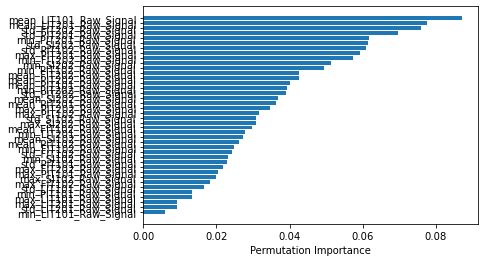

In [50]:
#Find the most important features
perm_importance = permutation_importance(model_v3, X_val, y_val_det)

features = np.array(learning_features)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

Classification report
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2050
           1       0.86      0.70      0.77       811

    accuracy                           0.88      2861
   macro avg       0.87      0.83      0.84      2861
weighted avg       0.88      0.88      0.88      2861





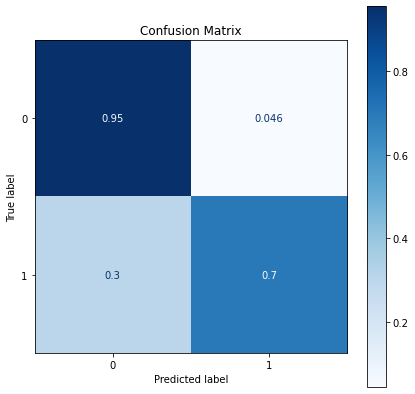

In [51]:
#print classification report
print('Classification report')
#model_v3.fit(X_val, y_train_det)
predict_val = model_v3.predict(X_val)
print(classification_report(y_val_det, predict_val))
print('\n')
    
#print normalized confusion matrix   
matrix = plot_confusion_matrix(model_v3, X_val, y_val_det, cmap=plt.cm.Blues, normalize='true')
matrix.ax_.set_title('Confusion Matrix')
fig = plt.gcf()
fig.set_size_inches(7, 7)
plt.show()